<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/gru_timeseries-withdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [23]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [25]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [26]:
def get_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [27]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [28]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

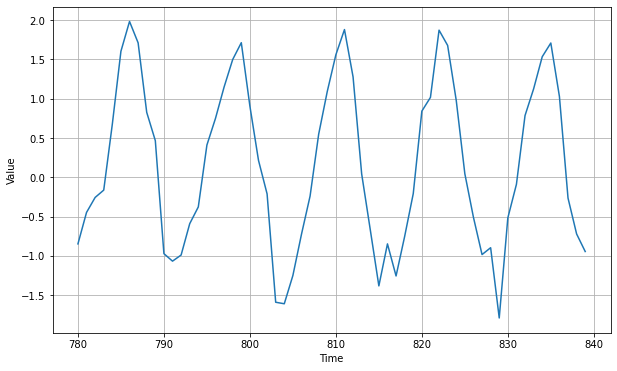

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
  tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=1000,  verbose=1, validation_data=valid_dataset)

Epoch 1/1000


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


38/38 [==============================] - 5s 48ms/step - loss: 0.4603 - mae: 0.8733 - val_loss: 0.5260 - val_mae: 0.9445
Epoch 2/1000
38/38 [==============================] - 1s 20ms/step - loss: 0.4579 - mae: 0.8700 - val_loss: 0.5245 - val_mae: 0.9425
Epoch 3/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.4568 - mae: 0.8682 - val_loss: 0.5230 - val_mae: 0.9405
Epoch 4/1000
38/38 [==============================] - 1s 20ms/step - loss: 0.4549 - mae: 0.8663 - val_loss: 0.5215 - val_mae: 0.9385
Epoch 5/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.4533 - mae: 0.8643 - val_loss: 0.5200 - val_mae: 0.9364
Epoch 6/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.4529 - mae: 0.8639 - val_loss: 0.5185 - val_mae: 0.9345
Epoch 7/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.4510 - mae: 0.8616 - val_loss: 0.5170 - val_mae: 0.9324
Epoch 8/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.4496 

38/38 [==============================] - 1s 24ms/step - loss: 0.3767 - mae: 0.7722 - val_loss: 0.4353 - val_mae: 0.8294
Epoch 63/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.3740 - mae: 0.7693 - val_loss: 0.4336 - val_mae: 0.8275
Epoch 64/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.3732 - mae: 0.7684 - val_loss: 0.4320 - val_mae: 0.8256
Epoch 65/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.3719 - mae: 0.7662 - val_loss: 0.4304 - val_mae: 0.8237
Epoch 66/1000
38/38 [==============================] - 1s 30ms/step - loss: 0.3713 - mae: 0.7663 - val_loss: 0.4288 - val_mae: 0.8219
Epoch 67/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.3700 - mae: 0.7640 - val_loss: 0.4271 - val_mae: 0.8200
Epoch 68/1000
38/38 [==============================] - 1s 27ms/step - loss: 0.3666 - mae: 0.7595 - val_loss: 0.4255 - val_mae: 0.8182
Epoch 69/1000
38/38 [==============================] - 1s 24ms/step - loss: 

38/38 [==============================] - 1s 24ms/step - loss: 0.2804 - mae: 0.6509 - val_loss: 0.3181 - val_mae: 0.6873
Epoch 124/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.2770 - mae: 0.6484 - val_loss: 0.3159 - val_mae: 0.6843
Epoch 125/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.2740 - mae: 0.6415 - val_loss: 0.3136 - val_mae: 0.6813
Epoch 126/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.2743 - mae: 0.6421 - val_loss: 0.3114 - val_mae: 0.6783
Epoch 127/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.2664 - mae: 0.6329 - val_loss: 0.3090 - val_mae: 0.6752
Epoch 128/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.2664 - mae: 0.6332 - val_loss: 0.3067 - val_mae: 0.6721
Epoch 129/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.2633 - mae: 0.6266 - val_loss: 0.3044 - val_mae: 0.6689
Epoch 130/1000
38/38 [==============================] - 1s 24ms/step -

Epoch 184/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.1614 - mae: 0.4708 - val_loss: 0.1732 - val_mae: 0.4824
Epoch 185/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.1564 - mae: 0.4652 - val_loss: 0.1711 - val_mae: 0.4792
Epoch 186/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.1521 - mae: 0.4559 - val_loss: 0.1690 - val_mae: 0.4758
Epoch 187/1000
38/38 [==============================] - 1s 30ms/step - loss: 0.1529 - mae: 0.4573 - val_loss: 0.1669 - val_mae: 0.4725
Epoch 188/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.1499 - mae: 0.4538 - val_loss: 0.1647 - val_mae: 0.4691
Epoch 189/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.1511 - mae: 0.4552 - val_loss: 0.1627 - val_mae: 0.4659
Epoch 190/1000
38/38 [==============================] - 1s 30ms/step - loss: 0.1475 - mae: 0.4460 - val_loss: 0.1606 - val_mae: 0.4627
Epoch 191/1000
38/38 [==============================] -

Epoch 245/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0973 - mae: 0.3486 - val_loss: 0.0912 - val_mae: 0.3528
Epoch 246/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0965 - mae: 0.3520 - val_loss: 0.0907 - val_mae: 0.3522
Epoch 247/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0921 - mae: 0.3422 - val_loss: 0.0900 - val_mae: 0.3511
Epoch 248/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0914 - mae: 0.3431 - val_loss: 0.0895 - val_mae: 0.3505
Epoch 249/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0905 - mae: 0.3368 - val_loss: 0.0888 - val_mae: 0.3496
Epoch 250/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0895 - mae: 0.3386 - val_loss: 0.0886 - val_mae: 0.3496
Epoch 251/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0946 - mae: 0.3461 - val_loss: 0.0881 - val_mae: 0.3489
Epoch 252/1000
38/38 [==============================] -

Epoch 306/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.0817 - mae: 0.3176 - val_loss: 0.0752 - val_mae: 0.3241
Epoch 307/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0803 - mae: 0.3187 - val_loss: 0.0752 - val_mae: 0.3239
Epoch 308/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0764 - mae: 0.3108 - val_loss: 0.0751 - val_mae: 0.3239
Epoch 309/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0819 - mae: 0.3218 - val_loss: 0.0752 - val_mae: 0.3242
Epoch 310/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0816 - mae: 0.3196 - val_loss: 0.0750 - val_mae: 0.3237
Epoch 311/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0788 - mae: 0.3152 - val_loss: 0.0751 - val_mae: 0.3242
Epoch 312/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0816 - mae: 0.3197 - val_loss: 0.0749 - val_mae: 0.3238
Epoch 313/1000
38/38 [==============================] -

Epoch 367/1000
38/38 [==============================] - 1s 28ms/step - loss: 0.0835 - mae: 0.3250 - val_loss: 0.0721 - val_mae: 0.3185
Epoch 368/1000
38/38 [==============================] - 1s 27ms/step - loss: 0.0790 - mae: 0.3189 - val_loss: 0.0719 - val_mae: 0.3179
Epoch 369/1000
38/38 [==============================] - 1s 32ms/step - loss: 0.0783 - mae: 0.3103 - val_loss: 0.0717 - val_mae: 0.3171
Epoch 370/1000
38/38 [==============================] - 1s 37ms/step - loss: 0.0842 - mae: 0.3274 - val_loss: 0.0712 - val_mae: 0.3160
Epoch 371/1000
38/38 [==============================] - 1s 29ms/step - loss: 0.0764 - mae: 0.3118 - val_loss: 0.0714 - val_mae: 0.3165
Epoch 372/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.0822 - mae: 0.3222 - val_loss: 0.0710 - val_mae: 0.3153
Epoch 373/1000
38/38 [==============================] - 1s 31ms/step - loss: 0.0804 - mae: 0.3181 - val_loss: 0.0712 - val_mae: 0.3157
Epoch 374/1000
38/38 [==============================] -

Epoch 428/1000
38/38 [==============================] - 1s 27ms/step - loss: 0.0763 - mae: 0.3068 - val_loss: 0.0703 - val_mae: 0.3121
Epoch 429/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0727 - mae: 0.3019 - val_loss: 0.0704 - val_mae: 0.3127
Epoch 430/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0761 - mae: 0.3061 - val_loss: 0.0703 - val_mae: 0.3122
Epoch 431/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.0771 - mae: 0.3099 - val_loss: 0.0702 - val_mae: 0.3120
Epoch 432/1000
38/38 [==============================] - 1s 31ms/step - loss: 0.0804 - mae: 0.3201 - val_loss: 0.0701 - val_mae: 0.3120
Epoch 433/1000
38/38 [==============================] - 1s 28ms/step - loss: 0.0818 - mae: 0.3193 - val_loss: 0.0703 - val_mae: 0.3122
Epoch 434/1000
38/38 [==============================] - 1s 27ms/step - loss: 0.0745 - mae: 0.3103 - val_loss: 0.0700 - val_mae: 0.3117
Epoch 435/1000
38/38 [==============================] -

Epoch 489/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0791 - mae: 0.3156 - val_loss: 0.0691 - val_mae: 0.3083
Epoch 490/1000
38/38 [==============================] - 1s 30ms/step - loss: 0.0795 - mae: 0.3174 - val_loss: 0.0692 - val_mae: 0.3086
Epoch 491/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.0783 - mae: 0.3141 - val_loss: 0.0693 - val_mae: 0.3089
Epoch 492/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.0776 - mae: 0.3150 - val_loss: 0.0689 - val_mae: 0.3079
Epoch 493/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0755 - mae: 0.3072 - val_loss: 0.0690 - val_mae: 0.3080
Epoch 494/1000
38/38 [==============================] - 1s 29ms/step - loss: 0.0713 - mae: 0.3012 - val_loss: 0.0694 - val_mae: 0.3094
Epoch 495/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.0738 - mae: 0.3079 - val_loss: 0.0693 - val_mae: 0.3090
Epoch 496/1000
38/38 [==============================] -

Epoch 550/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0762 - mae: 0.3132 - val_loss: 0.0679 - val_mae: 0.3043
Epoch 551/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0752 - mae: 0.3083 - val_loss: 0.0681 - val_mae: 0.3050
Epoch 552/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0765 - mae: 0.3081 - val_loss: 0.0680 - val_mae: 0.3050
Epoch 553/1000
38/38 [==============================] - 1s 21ms/step - loss: 0.0784 - mae: 0.3107 - val_loss: 0.0680 - val_mae: 0.3049
Epoch 554/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0759 - mae: 0.3087 - val_loss: 0.0679 - val_mae: 0.3046
Epoch 555/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0764 - mae: 0.3158 - val_loss: 0.0678 - val_mae: 0.3042
Epoch 556/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0750 - mae: 0.3065 - val_loss: 0.0676 - val_mae: 0.3038
Epoch 557/1000
38/38 [==============================] -

Epoch 611/1000
38/38 [==============================] - 1s 28ms/step - loss: 0.0730 - mae: 0.3021 - val_loss: 0.0669 - val_mae: 0.3013
Epoch 612/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.0693 - mae: 0.2977 - val_loss: 0.0669 - val_mae: 0.3013
Epoch 613/1000
38/38 [==============================] - 1s 28ms/step - loss: 0.0770 - mae: 0.3084 - val_loss: 0.0669 - val_mae: 0.3013
Epoch 614/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0736 - mae: 0.3080 - val_loss: 0.0669 - val_mae: 0.3016
Epoch 615/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0747 - mae: 0.3050 - val_loss: 0.0671 - val_mae: 0.3020
Epoch 616/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.0757 - mae: 0.3075 - val_loss: 0.0670 - val_mae: 0.3019
Epoch 617/1000
38/38 [==============================] - 1s 27ms/step - loss: 0.0744 - mae: 0.3104 - val_loss: 0.0668 - val_mae: 0.3015
Epoch 618/1000
38/38 [==============================] -

Epoch 672/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0751 - mae: 0.3076 - val_loss: 0.0665 - val_mae: 0.2995
Epoch 673/1000
38/38 [==============================] - 1s 22ms/step - loss: 0.0733 - mae: 0.3038 - val_loss: 0.0662 - val_mae: 0.2988
Epoch 674/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0776 - mae: 0.3137 - val_loss: 0.0662 - val_mae: 0.2988
Epoch 675/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0747 - mae: 0.3044 - val_loss: 0.0662 - val_mae: 0.2988
Epoch 676/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0732 - mae: 0.3025 - val_loss: 0.0659 - val_mae: 0.2979
Epoch 677/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0772 - mae: 0.3129 - val_loss: 0.0661 - val_mae: 0.2985
Epoch 678/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0714 - mae: 0.2989 - val_loss: 0.0660 - val_mae: 0.2983
Epoch 679/1000
38/38 [==============================] -

Epoch 733/1000
38/38 [==============================] - 1s 32ms/step - loss: 0.0720 - mae: 0.2979 - val_loss: 0.0653 - val_mae: 0.2956
Epoch 734/1000
38/38 [==============================] - 1s 37ms/step - loss: 0.0717 - mae: 0.2974 - val_loss: 0.0651 - val_mae: 0.2952
Epoch 735/1000
38/38 [==============================] - 2s 40ms/step - loss: 0.0706 - mae: 0.2959 - val_loss: 0.0656 - val_mae: 0.2966
Epoch 736/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.0745 - mae: 0.3068 - val_loss: 0.0657 - val_mae: 0.2969
Epoch 737/1000
38/38 [==============================] - 1s 38ms/step - loss: 0.0666 - mae: 0.2892 - val_loss: 0.0658 - val_mae: 0.2974
Epoch 738/1000
38/38 [==============================] - 1s 32ms/step - loss: 0.0718 - mae: 0.3004 - val_loss: 0.0660 - val_mae: 0.2977
Epoch 739/1000
38/38 [==============================] - 1s 30ms/step - loss: 0.0756 - mae: 0.3070 - val_loss: 0.0658 - val_mae: 0.2972
Epoch 740/1000
38/38 [==============================] -

Epoch 794/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0729 - mae: 0.2988 - val_loss: 0.0648 - val_mae: 0.2936
Epoch 795/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0737 - mae: 0.3033 - val_loss: 0.0649 - val_mae: 0.2940
Epoch 796/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0720 - mae: 0.3030 - val_loss: 0.0649 - val_mae: 0.2939
Epoch 797/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0785 - mae: 0.3118 - val_loss: 0.0649 - val_mae: 0.2940
Epoch 798/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0754 - mae: 0.3048 - val_loss: 0.0647 - val_mae: 0.2931
Epoch 799/1000
38/38 [==============================] - 1s 27ms/step - loss: 0.0760 - mae: 0.3051 - val_loss: 0.0647 - val_mae: 0.2931
Epoch 800/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0745 - mae: 0.3059 - val_loss: 0.0646 - val_mae: 0.2930
Epoch 801/1000
38/38 [==============================] -

Epoch 855/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0704 - mae: 0.2971 - val_loss: 0.0644 - val_mae: 0.2924
Epoch 856/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0729 - mae: 0.3035 - val_loss: 0.0645 - val_mae: 0.2925
Epoch 857/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0690 - mae: 0.2939 - val_loss: 0.0646 - val_mae: 0.2929
Epoch 858/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0750 - mae: 0.3068 - val_loss: 0.0645 - val_mae: 0.2926
Epoch 859/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0706 - mae: 0.2993 - val_loss: 0.0646 - val_mae: 0.2927
Epoch 860/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0687 - mae: 0.2957 - val_loss: 0.0647 - val_mae: 0.2929
Epoch 861/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0709 - mae: 0.2941 - val_loss: 0.0646 - val_mae: 0.2927
Epoch 862/1000
38/38 [==============================] -

Epoch 916/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0724 - mae: 0.2981 - val_loss: 0.0637 - val_mae: 0.2893
Epoch 917/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0704 - mae: 0.2953 - val_loss: 0.0635 - val_mae: 0.2889
Epoch 918/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0734 - mae: 0.3016 - val_loss: 0.0636 - val_mae: 0.2893
Epoch 919/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0706 - mae: 0.2968 - val_loss: 0.0636 - val_mae: 0.2891
Epoch 920/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0746 - mae: 0.3051 - val_loss: 0.0636 - val_mae: 0.2892
Epoch 921/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0767 - mae: 0.3092 - val_loss: 0.0637 - val_mae: 0.2897
Epoch 922/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0732 - mae: 0.2987 - val_loss: 0.0639 - val_mae: 0.2902
Epoch 923/1000
38/38 [==============================] -

Epoch 977/1000
38/38 [==============================] - 1s 23ms/step - loss: 0.0674 - mae: 0.2900 - val_loss: 0.0631 - val_mae: 0.2872
Epoch 978/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0678 - mae: 0.2919 - val_loss: 0.0629 - val_mae: 0.2868
Epoch 979/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.0723 - mae: 0.3013 - val_loss: 0.0631 - val_mae: 0.2873
Epoch 980/1000
38/38 [==============================] - 1s 25ms/step - loss: 0.0668 - mae: 0.2929 - val_loss: 0.0632 - val_mae: 0.2876
Epoch 981/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0661 - mae: 0.2866 - val_loss: 0.0633 - val_mae: 0.2878
Epoch 982/1000
38/38 [==============================] - 1s 26ms/step - loss: 0.0719 - mae: 0.2954 - val_loss: 0.0633 - val_mae: 0.2877
Epoch 983/1000
38/38 [==============================] - 1s 24ms/step - loss: 0.0711 - mae: 0.2981 - val_loss: 0.0634 - val_mae: 0.2881
Epoch 984/1000
38/38 [==============================] -

In [32]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [33]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 0s 30ms/step


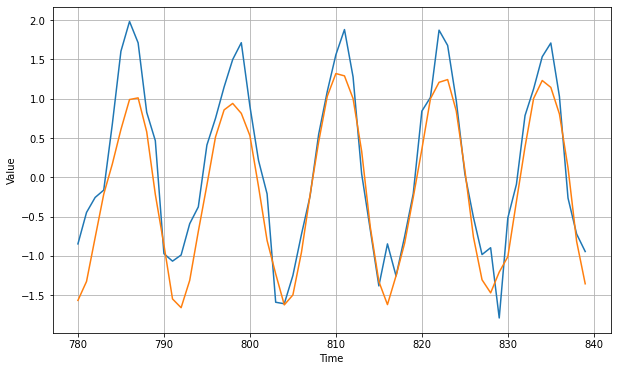

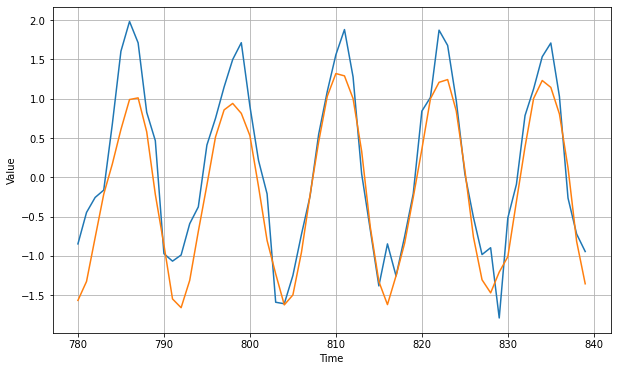

In [34]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()


In [35]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.3753959


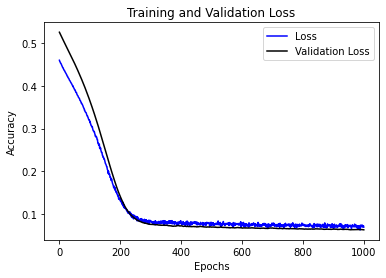

<Figure size 432x288 with 0 Axes>

In [36]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
